# ネットワークデータの読み込み

In [15]:
import pypsa

# 最適化済みネットワークデータを読み込む
network = pypsa.Network('./complete_network/optimized_network_2024.nc')
print(f"ネットワークデータを読み込みました: {len(network.buses)} buses, {len(network.generators)} generators")

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks


ネットワークデータを読み込みました: 49 buses, 210 generators


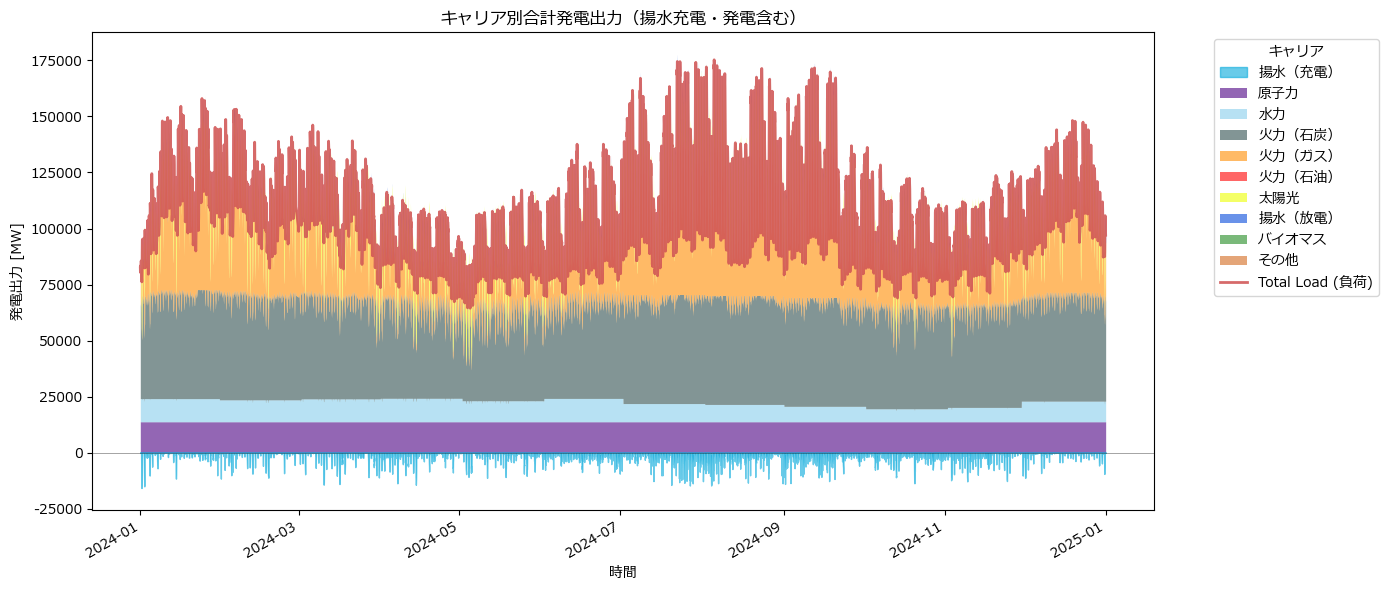

表示期間: 2024-05-01 00:00:00 ~ 2024-05-14 00:00:00 (313時間)


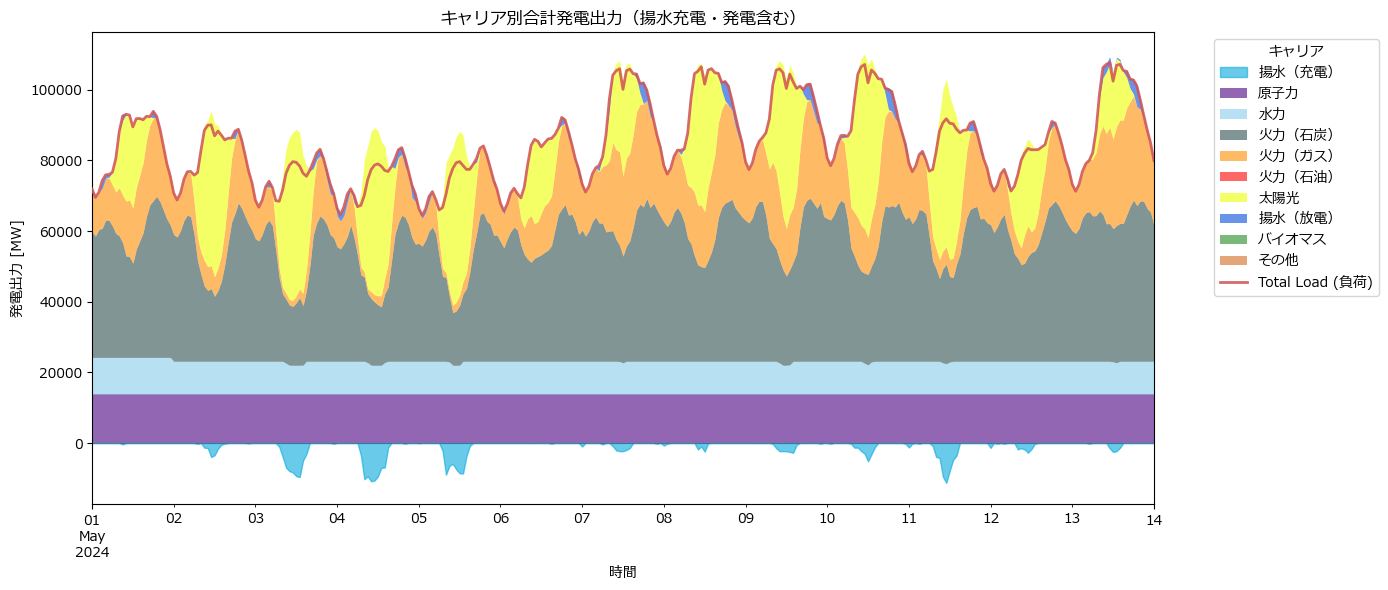

In [31]:
# 需給シミュレーション結果を表示
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)
analyze_results.plot_total_generation_by_carrier(network)
analyze_results.plot_total_generation_by_carrier(network, start_date="2024-05-01", end_date="2024-05-14")

ネットワーク内のcarrier一覧:
['その他', 'バイオマス', '原子力', '太陽光', '水力', '火力（ガス）', '火力（石油）', '火力（石炭）']


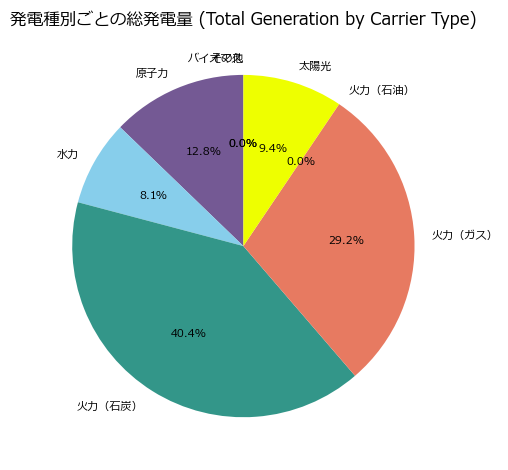

In [25]:
# 需給シミュレーション結果を表示
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)
analyze_results.plot_generation_mix_in_total_in_pie_graph(network)

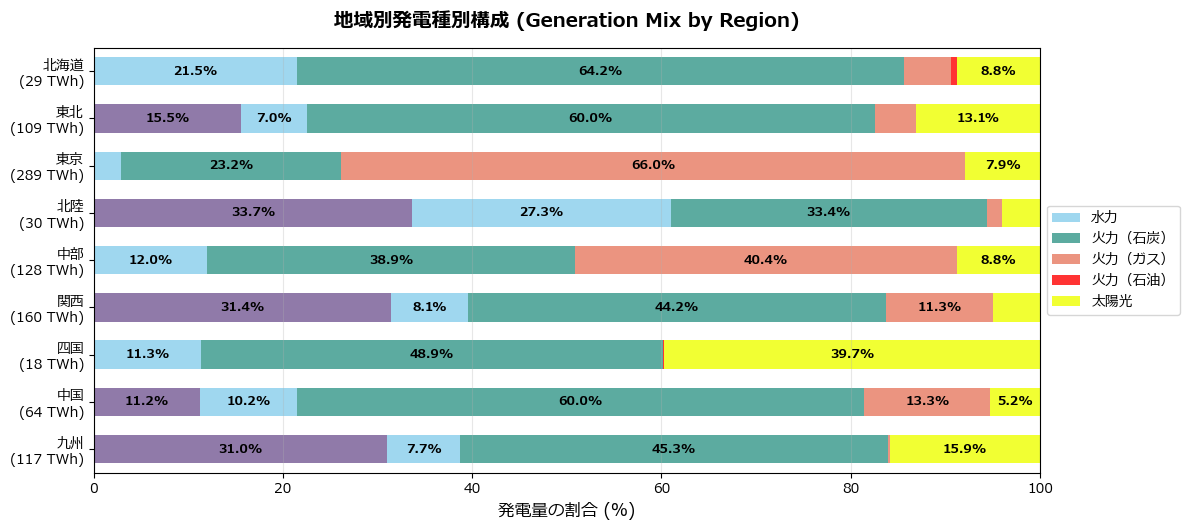

In [36]:
# 地域別発電量構成
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)

analyze_results.plot_generation_by_bus(network)

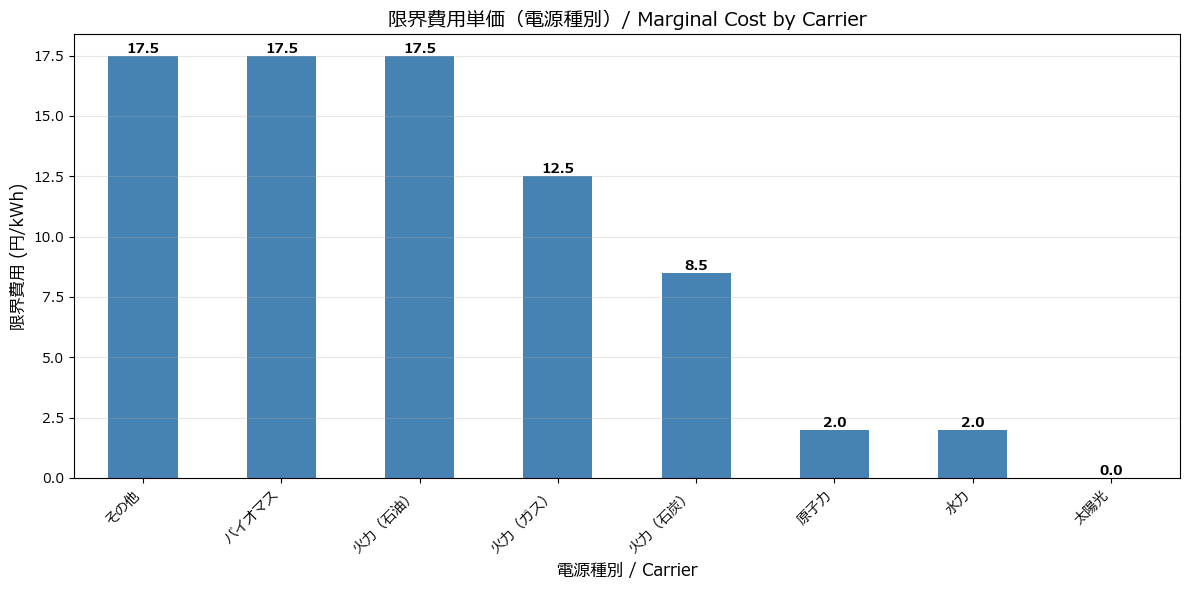

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 日本語フォント設定
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# 電源種別ごとの限界費用単価を取得
marginal_costs = network.generators.groupby('carrier')['marginal_cost'].first()

# 円/MWhから円/kWhに変換（1000で割る）
marginal_costs_per_kwh = marginal_costs / 1000

# 限界費用でソート
marginal_costs_per_kwh = marginal_costs_per_kwh.sort_values(ascending=False)

# 棒グラフで表示
fig, ax = plt.subplots(figsize=(12, 6))
bars = marginal_costs_per_kwh.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('限界費用単価（電源種別）/ Marginal Cost by Carrier', fontsize=14)
ax.set_ylabel('限界費用 (円/kWh)', fontsize=12)
ax.set_xlabel('電源種別 / Carrier', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# 各棒グラフの上に数値を表示
for i, (idx, value) in enumerate(marginal_costs_per_kwh.items()):
    ax.text(i, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

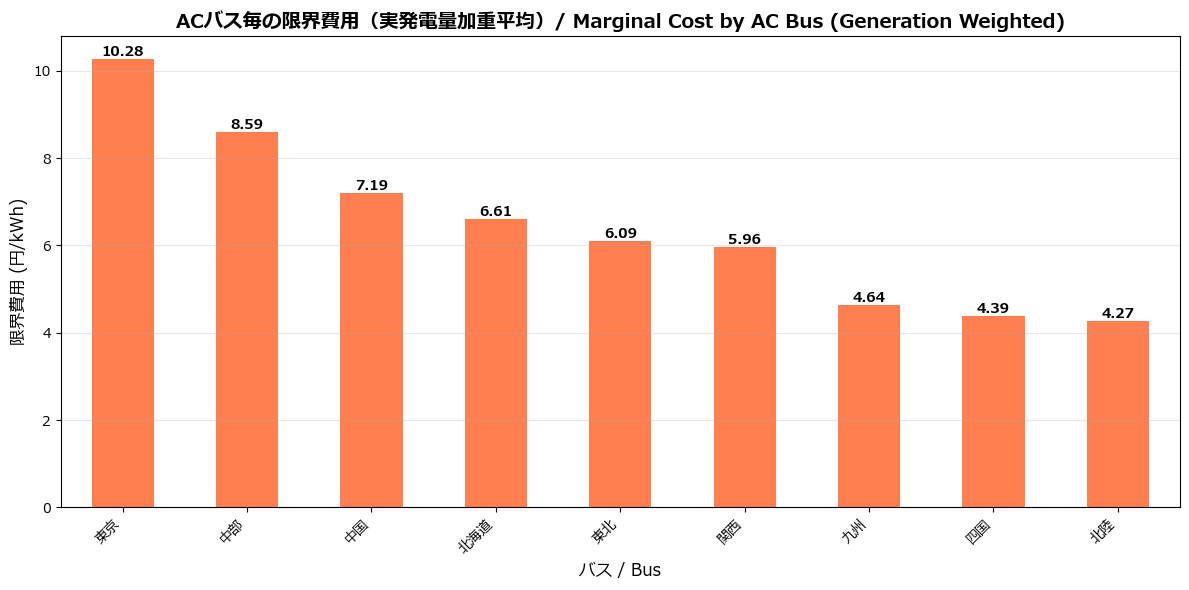


ACバス毎の限界費用（実発電量加重平均） (円/kWh):
--------------------------------------------------
東京        :  10.28 円/kWh
中部        :   8.59 円/kWh
中国        :   7.19 円/kWh
北海道       :   6.61 円/kWh
東北        :   6.09 円/kWh
関西        :   5.96 円/kWh
九州        :   4.64 円/kWh
四国        :   4.39 円/kWh
北陸        :   4.27 円/kWh


In [ ]:
# ACバス毎の実際の発電量加重平均Marginal Costを計算

# ACバスに接続されている発電機を抽出
ac_buses = network.buses[network.buses['carrier'] == 'AC'].index
ac_generators = network.generators[network.generators['bus'].isin(ac_buses)]

# バス毎に発電量加重平均Marginal Costを計算
marginal_cost_by_generation = {}
for bus in ac_buses:
    gens_at_bus = ac_generators[ac_generators['bus'] == bus]
    if len(gens_at_bus) > 0:
        # 各発電機の実際の発電量を取得
        generation = network.generators_t.p[gens_at_bus.index].sum().sum()  # 総発電量
        
        if generation > 0:
            # 発電量で加重平均
            weighted_cost = 0
            for gen in gens_at_bus.index:
                gen_total = network.generators_t.p[gen].sum()
                gen_marginal_cost = gens_at_bus.loc[gen, 'marginal_cost']
                weighted_cost += gen_total * gen_marginal_cost
            
            weighted_cost = weighted_cost / generation / 1000  # 円/kWhに変換
            marginal_cost_by_generation[bus] = weighted_cost

# Seriesに変換してソート
marginal_cost_gen_series = pd.Series(marginal_cost_by_generation).sort_values(ascending=False)

# 棒グラフで表示
fig, ax = plt.subplots(figsize=(12, 6))
bars = marginal_cost_gen_series.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('ACバス毎の限界費用（実発電量加重平均）/ Marginal Cost by AC Bus (Generation Weighted)', fontsize=14, fontweight='bold')
ax.set_ylabel('限界費用 (円/kWh)', fontsize=12)
ax.set_xlabel('バス / Bus', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# 各棒グラフの上に数値を表示
for i, (bus, cost) in enumerate(marginal_cost_gen_series.items()):
    ax.text(i, cost, f'{cost:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 数値データも表示
print("\nACバス毎の限界費用（実発電量加重平均） (円/kWh):")
print("-" * 50)
for bus, cost in marginal_cost_gen_series.items():
    print(f"{bus:10s}: {cost:6.2f} 円/kWh")

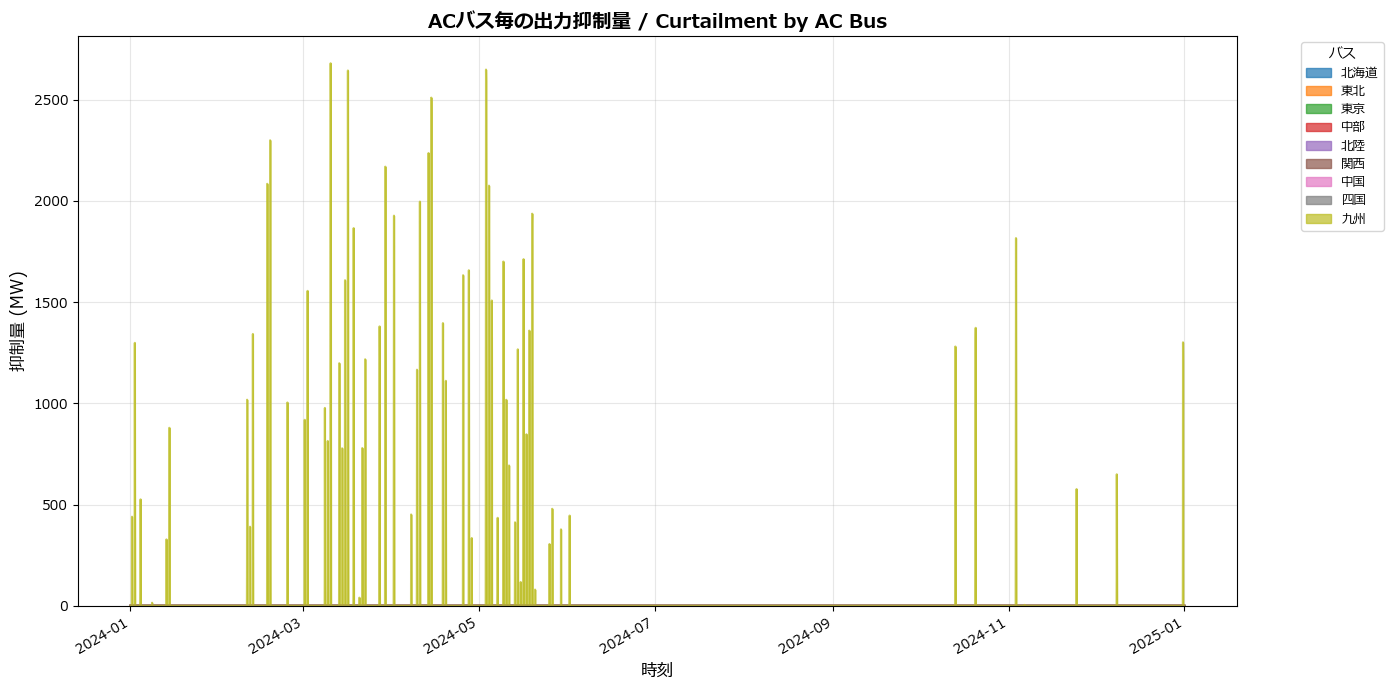


出力抑制量の集計結果

全体の総抑制量: 185,616.66 MWh
              = 185.62 GWh
              = 0.1856 TWh


バス毎の総抑制量 (MWh):
------------------------------------------------------------
九州             : 185,616.66 MWh (100.00%)
関西             :       0.00 MWh ( 0.00%)
北陸             :       0.00 MWh ( 0.00%)
東北             :       0.00 MWh ( 0.00%)
東京             :       0.00 MWh ( 0.00%)
中部             :       0.00 MWh ( 0.00%)
北海道            :       0.00 MWh ( 0.00%)
四国             :       0.00 MWh ( 0.00%)
中国             :       0.00 MWh ( 0.00%)


In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# 日本語フォント設定
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# ネットワークの出力抑制（curtailment）を計算
curtailment = network.generators_t.p_max_pu * network.generators.p_nom - network.generators_t.p
curtailment_positive = curtailment.clip(lower=0)

# ACバスに接続されている発電機を抽出
ac_buses = network.buses[network.buses['carrier'] == 'AC'].index
ac_generators = network.generators[network.generators['bus'].isin(ac_buses)]

# バス毎に抑制量を集計
curtailment_by_bus = {}
for bus in ac_buses:
    # このバスに接続されている発電機
    gens_at_bus = ac_generators[ac_generators['bus'] == bus].index
    if len(gens_at_bus) > 0:
        # このバスの発電機の抑制量を合計
        bus_curtailment = curtailment_positive[gens_at_bus].sum(axis=1)
        curtailment_by_bus[bus] = bus_curtailment

# DataFrameに変換
df_curtailment_by_bus = pd.DataFrame(curtailment_by_bus)

# 積み上げ面グラフで表示
fig, ax = plt.subplots(figsize=(14, 7))
df_curtailment_by_bus.plot.area(ax=ax, stacked=True, alpha=0.7)
ax.set_title('ACバス毎の出力抑制量 / Curtailment by AC Bus', fontsize=14, fontweight='bold')
ax.set_ylabel('抑制量 (MW)', fontsize=12)
ax.set_xlabel('時刻', fontsize=12)
ax.legend(title='バス', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# バス毎の総抑制量を表示
total_curtailment_by_bus = df_curtailment_by_bus.sum()
total_curtailment_all = total_curtailment_by_bus.sum()

print("\n" + "="*60)
print("出力抑制量の集計結果")
print("="*60)
print(f"\n全体の総抑制量: {total_curtailment_all:,.2f} MWh")
print(f"              = {total_curtailment_all/1000:,.2f} GWh")
print(f"              = {total_curtailment_all/1000000:,.4f} TWh")

print("\n\nバス毎の総抑制量 (MWh):")
print("-"*60)
for bus, value in total_curtailment_by_bus.sort_values(ascending=False).items():
    percentage = (value / total_curtailment_all * 100) if total_curtailment_all > 0 else 0
    print(f"{bus:15s}: {value:10,.2f} MWh ({percentage:5.2f}%)")

# 送電線の潮流を表示

プロット対象の連系線: 10本
['北海道本州連系設備', '東北東京間連系線', '東京中部間連系線', '中部北陸連系設備', '中部関西連系線', '北陸関西連系線', '関西中国間連系線', '関西四国間連系設備', '中国四国間連系線', '中国九州間連系線']


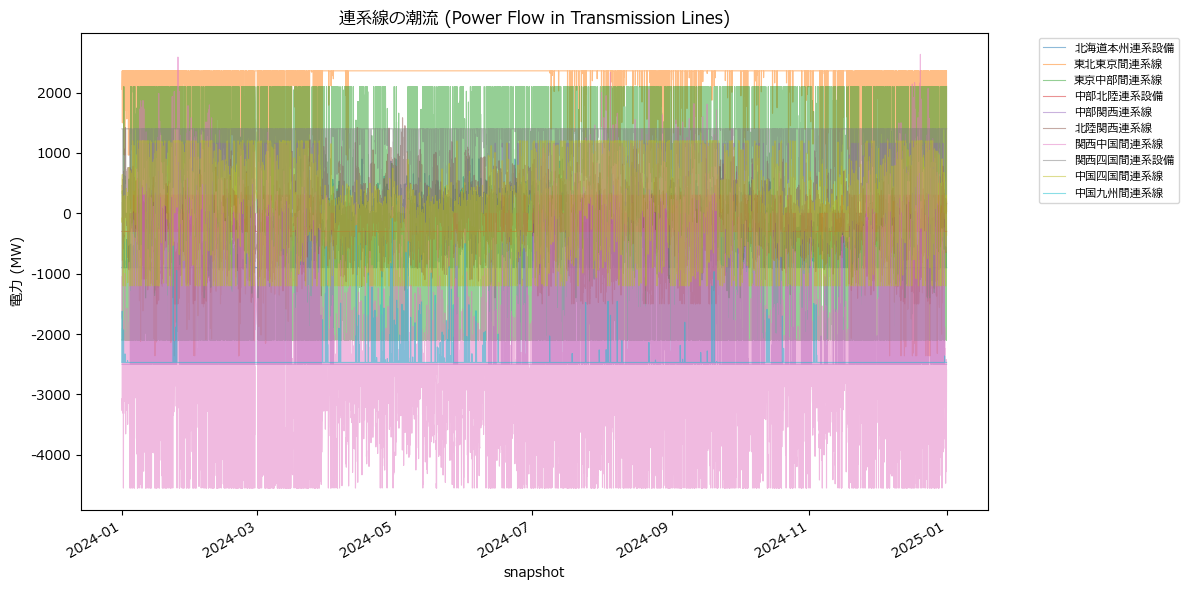

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止

# 連系線のみをフィルタリング（carrier='DC'または名前に'連系'を含むリンク）
transmission_links = network.links[
    (network.links['carrier'] == 'DC') | 
    (network.links.index.str.contains('連系', na=False))
].index

if len(transmission_links) > 0:
    ax = network.links_t.p0[transmission_links].plot(
        title="連系線の潮流 (Power Flow in Transmission Lines)", 
        figsize=(12, 6),
        ylabel="電力 (MW)",
        alpha=0.5,
        linewidth=0.8
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    print(f"プロット対象の連系線: {len(transmission_links)}本")
    print(transmission_links.tolist())
else:
    print("連系線が見つかりませんでした")

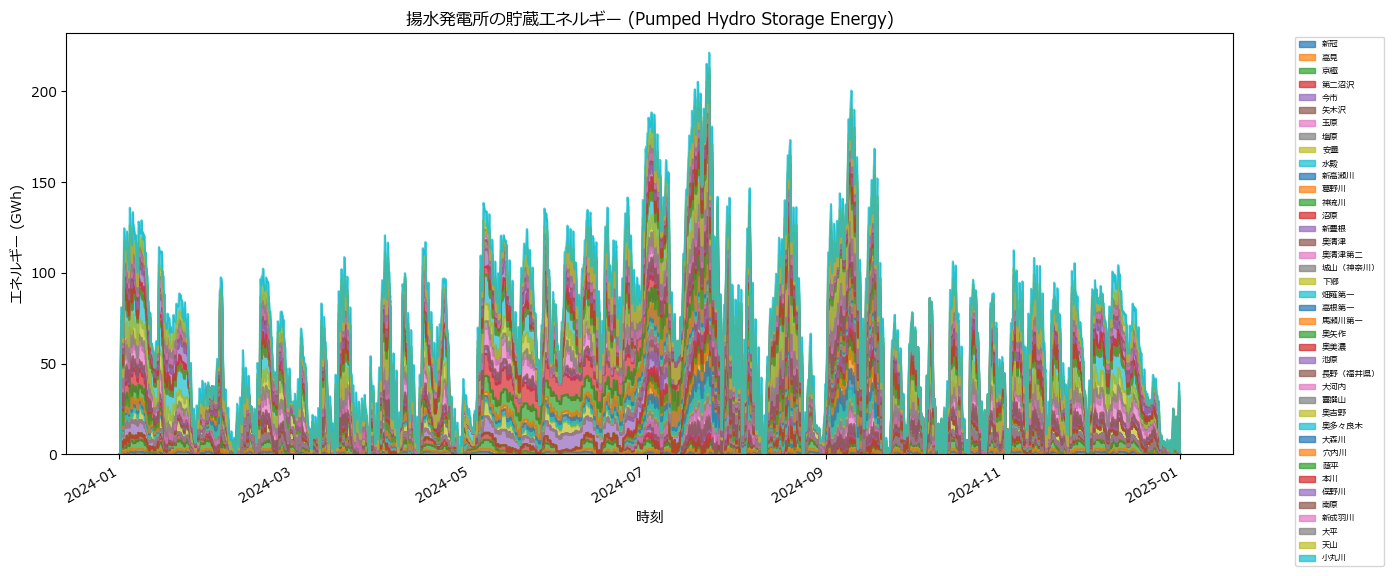

In [32]:
# 揚水発電所の貯蔵エネルギー（蓄電状態）を積み上げグラフでプロット
if len(network.stores) > 0:
    # 揚水発電所（Store）の蓄電量時系列データを取得
    storage_energy = network.stores_t.e
    
    # 負の値を0にクリップ（誤差処理）
    storage_energy = storage_energy.clip(lower=0)
    
    if not storage_energy.empty:
        # MWhからGWhに変換
        storage_energy_gwh = storage_energy / 1000
        
        fig, ax = plt.subplots(figsize=(14, 6))
        storage_energy_gwh.plot(
            ax=ax, 
            kind='area',
            stacked=True,
            alpha=0.7,
            title='揚水発電所の貯蔵エネルギー (Pumped Hydro Storage Energy)', 
            ylabel='エネルギー (GWh)', 
            xlabel='時刻'
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
        plt.tight_layout()
        plt.show()
    else:
        print("揚水発電所の貯蔵エネルギーデータがありません")
else:
    print("ネットワークに揚水発電所（Store）が含まれていません")


INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:Imported netw

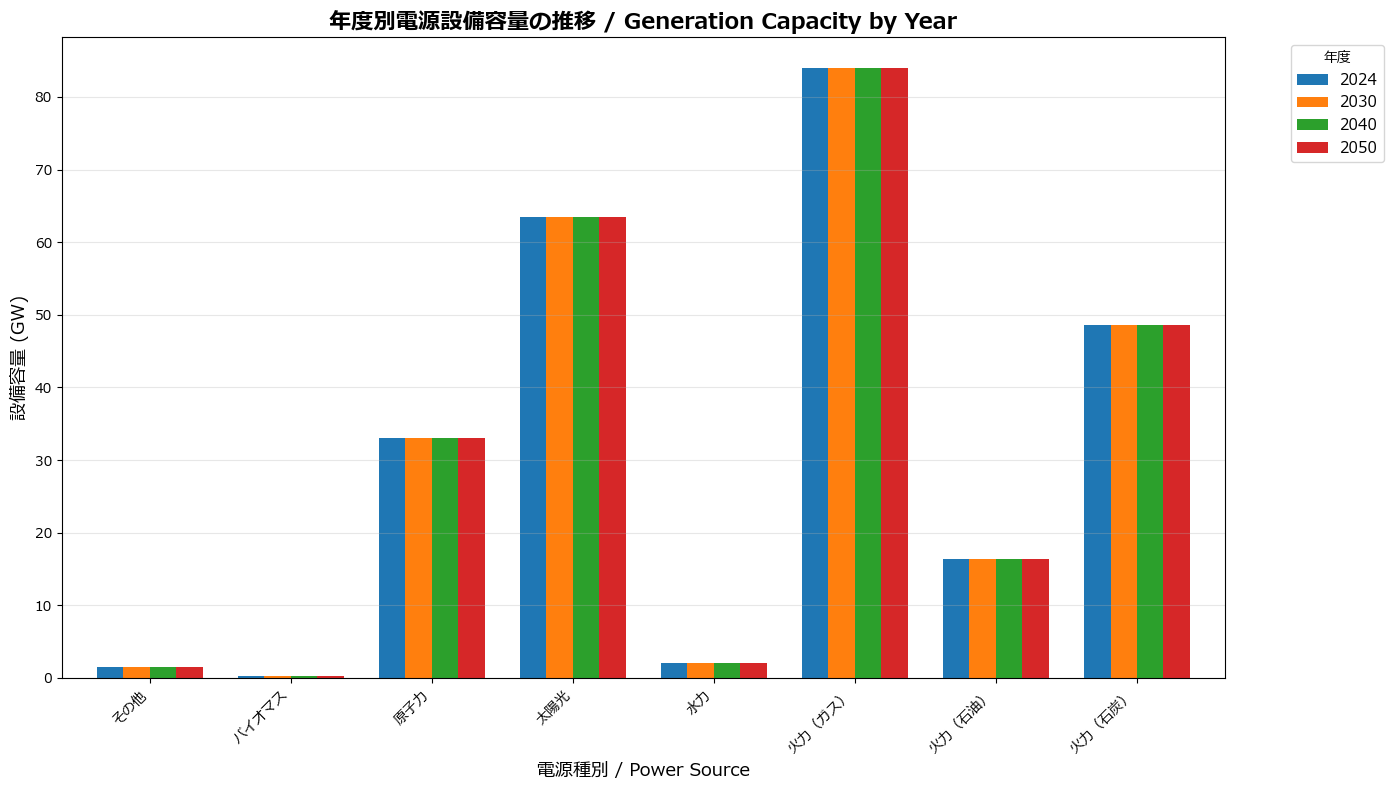


電源設備容量 (GW)
          2024   2030   2040   2050
carrier                            
その他       1.54   1.54   1.54   1.54
バイオマス     0.22   0.22   0.22   0.22
原子力      33.08  33.08  33.08  33.08
太陽光      63.52  63.52  63.52  63.52
水力        2.10   2.10   2.10   2.10
火力（ガス）   84.01  84.01  84.01  84.01
火力（石油）   16.39  16.39  16.39  16.39
火力（石炭）   48.66  48.66  48.66  48.66

総設備容量 (GW)
2024    249.52
2030    249.52
2040    249.52
2050    249.52
dtype: float64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

# 日本語フォント設定
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# 各年度のネットワークファイルを読み込んで設備容量を計算
years = [2024, 2030, 2040, 2050]
capacity_data = {}

for year in years:
    # ネットワークを読み込む
    net = pypsa.Network(f'./complete_network/optimized_network_{year}.nc')
    
    # 電源種別ごとの設備容量を計算（p_nom: 定格容量）
    capacity_by_carrier = net.generators.groupby('carrier')['p_nom'].sum()
    
    # GWに変換（MWから）
    capacity_data[str(year)] = (capacity_by_carrier / 1000).round(2)

# DataFrameに変換
df_capacity = pd.DataFrame(capacity_data)

# 棒グラフで表示
fig, ax = plt.subplots(figsize=(14, 8))
df_capacity.plot(kind='bar', ax=ax, width=0.75)

ax.set_title('年度別電源設備容量の推移 / Generation Capacity by Year', fontsize=16, fontweight='bold')
ax.set_ylabel('設備容量 (GW)', fontsize=13)
ax.set_xlabel('電源種別 / Power Source', fontsize=13)
ax.legend(title='年度', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 数値データも表示
print("\n電源設備容量 (GW)")
print(df_capacity)
print(f"\n総設備容量 (GW)")
print(df_capacity.sum())
